<a href="https://colab.research.google.com/github/EmilSeyfullayev/Mercedes/blob/main/0_MercedesParser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# #About first threee cells
# #In order to use colab with google drive with no authentication each time you have run this cell
# #Then you will have to run next cell to copy client_id, client secret and refresh_token
# #once you did thah you paste them in third cell and by running third cell only you dont need to authenticate each time
# # while third cell is run, adc.json file is created
from google.colab import auth
auth.authenticate_user()

In [ ]:
!cat adc.json

{
  "client_id": "32555940559.apps.googleusercontent.com",
  "client_secret": "ZmssLNjJy2998hD4CTg2ejr2",
  "refresh_token": "1//05eKPtUa3e_AvCgYIARAAGAUSNwF-L9IrH_E7B7hAkttu6taSU5V9PNl78lqcN1V35aHkYzeHXNGp6c8u8o6HJPd2qEDH65l_wCg",
  "revoke_uri": "https://accounts.google.com/o/oauth2/revoke",
  "scopes": [
    "openid",
    "https://www.googleapis.com/auth/userinfo.email",
    "https://www.googleapis.com/auth/cloud-platform",
    "https://www.googleapis.com/auth/appengine.admin",
    "https://www.googleapis.com/auth/compute",
    "https://www.googleapis.com/auth/accounts.reauth",
    "https://www.googleapis.com/auth/drive"
  ],
  "token_uri": "https://oauth2.googleapis.com/token",
  "type": "authorized_user"
}

In [ ]:
!pip install -U -q PyDrive

import httplib2
import json

from google.colab import auth
from oauth2client import GOOGLE_REVOKE_URI, GOOGLE_TOKEN_URI, client
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth_key = {
  "client_id": "32555940559.apps.googleusercontent.com",
  "client_secret": "ZmssLNjJy2998hD4CTg2ejr2",
  "refresh_token": "1//05eKPtUa3e_AvCgYIARAAGAUSNwF-L9IrH_E7B7hAkttu6taSU5V9PNl78lqcN1V35aHkYzeHXNGp6c8u8o6HJPd2qEDH65l_wCg"
}

credentials = client.OAuth2Credentials(
    access_token=None,
    client_id=auth_key['client_id'],
    client_secret=auth_key['client_secret'],
    refresh_token=auth_key['refresh_token'],
    token_expiry=None,
    token_uri=GOOGLE_TOKEN_URI,
    user_agent=None,
    revoke_uri=GOOGLE_REVOKE_URI)

credentials.refresh(httplib2.Http())
credentials.authorize(httplib2.Http())
cred = json.loads(credentials.to_json())
cred['type'] = 'authorized_user'

with open('adc.json', 'w') as outfile:
  json.dump(cred, outfile)

In [ ]:
from bs4 import BeautifulSoup
import requests
import sqlite3
import pandas as pd
import numpy as np
from datetime import timezone, tzinfo
import pytz
import datetime         # datetime.datetime.now()
import time             # time.sleep(int(secs))

In [ ]:
HOST = "https://turbo.az/"
HEADERS = {
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"
}

In [ ]:
url = "https://turbo.az/autos?utf8=%E2%9C%93&q%5Bmake%5D%5B%5D=4&q%5Bcurrency%5D=azn&q%5Bprice_from%5D=&q%5Bprice_to%5D=&q%5Bloan%5D=0&q%5Bregion%5D%5B%5D=&commit=&q%5Bmodel%5D%5B%5D=&q%5Byear_from%5D=&q%5Byear_to%5D=&q%5Bbarter%5D=0&q%5Bsort%5D="
html = requests.get(url, headers=HEADERS).content
soup = BeautifulSoup(html, "html.parser")
last_page = int(soup.find("nav", class_="pagination").find("span", {"class":"last"}).find("a").get("href").split("?page=")[1].split("&q%")[0])

In [ ]:
list_of_links = []
dates_times = []
vip_premium = []
loans = []
barters = []

for page_number in range(last_page):
  URL = "https://turbo.az/autos?page=" + str(page_number+1) + "&q%5Bmake%5D%5B%5D=" + str(4)

  requested_html = requests.get(URL, headers=HEADERS).content
  parsed_page = BeautifulSoup(requested_html, "html.parser")

  for product_section in parsed_page.find_all("div", "products"):
    try:
      product_section.find_previous_sibling("div", {"class":"products-title"}).find_all("p", {"class":"products-title-amount"})
    except AttributeError:
      pass
    else:

      #this is for parsing links in third section
      for tag_consisiting_of_href in product_section.find_all("a", class_="products-i-link"):
        list_of_links.append(HOST+tag_consisiting_of_href.get("href"))

      #this is for parsing dates and times in third section's each of the product (24)
      for date_and_time in product_section.findChildren("div", recursive=False):
        dates_times.append(date_and_time.find_all("div", class_="products-bottom")[0].text.split(", ")[1])

      #this is for vip, premium, etc
      for category in product_section.findChildren("div", recursive=False):
        vip_premium.append(category.get("class"))

      #this is for parsing loan availability information
      for loan in product_section.findChildren("div", recursive=False):
        if loan.find_all('div', class_='products-loan')==[]:
          loans.append(0)
        else:
          loans.append(1)

      #this is for parsing barter availability information
      for barter in product_section.findChildren("div", recursive=False):
        if barter.find_all('div', class_='products-barter')==[]:
          barters.append(0)
        else:
          barters.append(1)

      time.sleep(2) # in this place it will print out ok 8 times (as there are four sections)
      print("OK, parsed page number is "+str(page_number)+" out of "+str(last_page))
    
    

    

      

OK, parsed page number is 0 out of 311
OK, parsed page number is 1 out of 311
OK, parsed page number is 2 out of 311
OK, parsed page number is 3 out of 311
OK, parsed page number is 4 out of 311
OK, parsed page number is 5 out of 311
OK, parsed page number is 6 out of 311
OK, parsed page number is 7 out of 311
OK, parsed page number is 8 out of 311
OK, parsed page number is 9 out of 311
OK, parsed page number is 10 out of 311
OK, parsed page number is 11 out of 311
OK, parsed page number is 12 out of 311
OK, parsed page number is 13 out of 311
OK, parsed page number is 14 out of 311
OK, parsed page number is 15 out of 311
OK, parsed page number is 16 out of 311
OK, parsed page number is 17 out of 311
OK, parsed page number is 18 out of 311
OK, parsed page number is 19 out of 311
OK, parsed page number is 20 out of 311
OK, parsed page number is 21 out of 311
OK, parsed page number is 22 out of 311
OK, parsed page number is 23 out of 311
OK, parsed page number is 24 out of 311
OK, parsed

In [ ]:
print(len(list_of_links))
print(len(dates_times))
print(len(vip_premium))
print(len(loans))
print(len(barter))

7439
7439
7439


In [ ]:
descriptions = []
number_of_looks = []
productS_id = []
phone_book = []
avtosalon_name = []
extras = []
product_text = []
location = []
time_parsed = []
date_parsed = []

def car_properties_parser():

  for link in list_of_links:
    requested_html = requests.get(link, headers=HEADERS).content
    parsed_page = BeautifulSoup(requested_html, "html.parser")

    try:


      #this is for 14 important descriptions of a car
      for main_description_division in parsed_page.find_all("div", class_="product-properties-value")[0:14]: #14 in order not to consider Barter and kredit
        descriptions.append(main_description_division.text)

      #this is for parsing number of looks
      looks_quantity = parsed_page.find_all("div", {"class":"product-statistics"})[0].find_all("p")[0].text.split(" ")[2]
      number_of_looks.append(looks_quantity)

      #this is for parsing products id
      product_id = parsed_page.find_all("div", {"class":"product-statistics"})[0].find_all("p")[2].text.split(" ")[2]
      productS_id.append(product_id)

      #for parsing product text
      try:
        product_text.append(parsed_page.find(class_="product-text").text)
      except AttributeError:
        product_text.append("No text for product")

      #for parsing extras
      try:
        extras.append(parsed_page.find("div", class_="product-extras").text)
      except AttributeError:
        extras.append("No extras for product")

      #this is for parsing phone numbers

      try:
        phone_book.append(parsed_page.find(class_='phone').text)

      except AttributeError:
        phones = []
        for i in parsed_page.find_all(class_='shop-contact--phones-i'):
          phones.append(i.text)
        
        phone_book.append(phones)

      
      #for avtosalon name
      
      try:
        avtosalon_name.append(parsed_page.find(class_="shop--title").text)
      except AttributeError:
        avtosalon_name.append(0)

      try:
        location.append(parsed_page.find(class_="shop-contact--location-map shop--open-location-modal").find("img").get('src').split("markers=")[1].split("&size")[0])
      except AttributeError:
        location.append(0)

      date_parsed.append(datetime.datetime.now(pytz.timezone("Asia/Baku")).strftime("%H:%M:%S"))
      time_parsed.append(datetime.datetime.now(pytz.timezone("Asia/Baku")).strftime("%Y-%m-%d"))

      print("Parsed link number is " + str(list_of_links.index(link))+ " out of "+ str(len(list_of_links))+  " links.")
      time.sleep(1)

    except IndexError:

      descriptions.extend(list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
      number_of_looks.append(0)
      productS_id.append(0)
      phone_book.append(0)
      avtosalon_name.append(0)
      extras.append(0)
      product_text.append(0)
      location.append(0)
      time_parsed.append(0)
      date_parsed.append(0)

      print("Zeros were parsed in link "+ str(link))



car_properties_parser()

Streaming output truncated to the last 5000 lines.
Parsed link number is 2439 out of 7439 links.
Parsed link number is 2440 out of 7439 links.
Parsed link number is 2441 out of 7439 links.
Parsed link number is 2442 out of 7439 links.
Parsed link number is 2443 out of 7439 links.
Parsed link number is 2444 out of 7439 links.
Parsed link number is 2445 out of 7439 links.
Parsed link number is 2446 out of 7439 links.
Parsed link number is 2447 out of 7439 links.
Parsed link number is 2448 out of 7439 links.
Parsed link number is 2449 out of 7439 links.
Parsed link number is 2450 out of 7439 links.
Parsed link number is 2451 out of 7439 links.
Parsed link number is 2452 out of 7439 links.
Parsed link number is 2453 out of 7439 links.
Parsed link number is 2454 out of 7439 links.
Parsed link number is 2455 out of 7439 links.
Parsed link number is 2456 out of 7439 links.
Parsed link number is 2457 out of 7439 links.
Parsed link number is 2458 out of 7439 links.
Parsed link number is 2459 ou

In [ ]:
print(int(len(descriptions)/14))
print(len(number_of_looks))
print(len(productS_id))
print(len(phone_book))
print(len(avtosalon_name))
print(len(extras))
print(len(product_text))
print(len(location))
print(len(time_parsed))
print(len(date_parsed))
print(len(list_of_links))
print(len(dates_times))
print(len(vip_premium))
print(len(loans))
print(len(barters))

5954.0
5954
5954
5954
5954
5954
5954
5954
5954
5954
5954
5954
5954
5954
5954


In [ ]:
first_column_names = []

html = requests.get(list_of_links[0], headers=HEADERS).content
soup = BeautifulSoup(html, "html.parser")

for labels in soup.find_all("li", class_="product-properties-i"):
  for label in labels.find_all("label"):
    first_column_names.append(label.text)

data = pd.DataFrame(np.array(descriptions).reshape(-1, 14))

data.columns = first_column_names

data["Tarix_Saat"] = dates_times[1485:]
data["Kateqoriya"] = vip_premium[1485:]
data['Baxışların sayı'] = number_of_looks
data['Məhsulun id-si'] = productS_id
data['Link'] = list_of_links[1485:]
data['Kredit mümkündür'] = loans[1485:]
data['Barter mümkündür'] = barters[1485:]
data['Əlaqə nömrəsi'] = phone_book
data['Avtosalon adı'] = avtosalon_name
data['Ekstra parametrlər'] = extras
data['Məhsulun mətni'] = product_text
data['Yerləşmə məkanı'] = location
data['Parsinq olunan tarix'] = date_parsed
data['Parsinq olunan zaman'] = time_parsed

existed_in_db = []

for i in range(len(data)):
  existed_in_db.append(0)

data['existed_in_db'] = existed_in_db

In [ ]:
data = data.iloc[::-1].reset_index(drop=True)

In [ ]:
import gspread_dataframe as gd
import gspread as gs
gc = gs.authorize(GoogleCredentials.get_application_default())

#this is to write information for the first time
ws = gc.open("MercedesDataBase").worksheet("sheet_1")
gd.set_with_dataframe(ws, data, resize=True)

In [ ]:
##Preprocessing
df = pd.DataFrame()

#1 #2
df['city'] = data['Şəhər']
df['car_name'] = data['Marka']

#3
model_1 = []
model_2 = []
model_3 = []

for i in data['Model']:
  model_1.append(i.split(" ")[0])

  try:
    model_2.append(i.split(" ")[1])
  except IndexError:
    model_2.append(0)

  try:
    model_3.append(i.split(" ")[2])
  except IndexError:
    model_3.append(0)

df['model_1'] = model_1
df['model_2'] = model_2
df['model_3'] = model_3


#4, 5, 6
df['year'] = pd.to_numeric(data['Buraxılış ili'])
df['car_type'] = data['Ban növü']
df['color'] = data['Rəng']


#7
engine_volume = []

for i in data['Mühərrik']:
  engine_volume.append(i.split(" L")[0])

df['engine_volume'] = pd.to_numeric(engine_volume)

#8
horse_power = []

for i in data['Mühərrikin gücü']:
  horse_power.append(i.split(" a.g.")[0])

df['horse_power'] = pd.to_numeric(horse_power)

#9
df['fuel_type'] = data['Yanacaq növü']

#10
went = []

for i in data['Yürüş']:
  went.append(i.split(" km")[0].replace(" ", ""))

df['went'] = pd.to_numeric(went)

#11 #12 #13
df['gearbox'] = data['Sürətlər qutusu']
df['transmission'] = data['Ötürücü']
df['new'] = data['Yeni']

#14 #15
currency = []
price = []

for i in data['Qiymət']:
  currency.append(i.split(" ")[-1])

for i in data['Qiymət']:
  price.append("".join(i.split(" ")[0:-1]))

df['currency'] = currency
df['price'] = pd.to_numeric(price)

#16

date = []
time_hour = []
time_minute = []

for i in data['Tarix_Saat']:
  date.append(i.split(" ")[0])
  time_hour.append(i.split(" ")[1].split(":")[0])
  time_minute.append(i.split(" ")[1].split(":")[1])

df['date'] = pd.to_datetime(date, format="%d.%m.%Y" )
df['time_hour'] = pd.to_numeric(time_hour)
df['time_minute'] = pd.to_numeric(time_minute)

#17

values = ['products-i', 'vipped', 'featured', 'salon']

vip = []
featured = []
salon = []

for value in data['Kateqoriya']:
#########################################
  if values[1] in value:
    vip.append(1)
  elif values[1] not in value:
    vip.append(0)
########################################
for value in data['Kateqoriya']:
  if values[2] in value:
    featured.append(1)
  elif values[2] not in value:
    featured.append(0)
########################################
for value in data['Kateqoriya']:
  if values[3] in value:
    salon.append(1)
  elif values[3] not in value:
    salon.append(0)

df['vip'] = vip
df['featured'] = featured
df['salon'] = salon

#18 #19 #20 #21 #22
df['number_of-looks'] = pd.to_numeric(data['Baxışların sayı'])
df['id'] = pd.to_numeric(data['Məhsulun id-si'])
df['link'] = data['Link']
df['loan'] = data['Kredit mümkündür']
df['barter'] = data['Barter mümkündür']

#23 #24
# this one is tricky
#length of one string element (1 number is 15)
#lrngth of others (2 and more number counts) is roughly equals or less than 4 (4 numbers)

cell_phone_number = []

for i in data['Əlaqə nömrəsi']:
  if len(str(i)) > 14:
    cell_phone_number.append(i)
  else:
    cell_phone_number.append(", ".join(str(i)))

df['cell_phone_number'] = cell_phone_number
df['name_of_auto_salon'] = data['Avtosalon adı']

#25
extra_values = ['Yüngül lehimli disklər',
 'ABS', 'Lyuk', 'Yağış sensoru', 'Mərkəzi qapanma',
 'Park radarı', 'Kondisioner', 'Oturacaqların isidilməsi',
 'Dəri salon', 'Ksenon lampalar', 'Arxa görüntü kamerası',
 'Yan pərdələr', 'Oturacaqların ventilyasiyası']

alloy_wheels = [];    abs_auto_block = [];        luke = []
rain_sensors = [];    central_door_blocking = []; parking_radars = []
air_conditioner = []; seat_heating = [];          leather_interior = []
xenon_lights = [];    back_side_camera = [];      side_curtains = []
seat_ventilation = []

for i in data['Ekstra parametrlər']:
####disks
  if extra_values[0] in str(i):
    alloy_wheels.append(1)
  elif extra_values[0] not in str(i):
    alloy_wheels.append(0)

####abs
  if extra_values[1] in str(i):
    abs_auto_block.append(1)
  elif extra_values[1] not in str(i):
    abs_auto_block.append(0)


####luke
  if extra_values[2] in str(i):
    luke.append(1)
  elif extra_values[2] not in str(i):
    luke.append(0)

#rain_sensors
  if extra_values[3] in str(i):
    rain_sensors.append(1)
  elif extra_values[3] not in str(i):
    rain_sensors.append(0)

#central_door_blocking
  if extra_values[4] in str(i):
    central_door_blocking.append(1)
  elif extra_values[4] not in str(i):
    central_door_blocking.append(0)

#parking_radars
  if extra_values[5] in str(i):
    parking_radars.append(1)
  elif extra_values[5] not in str(i):
    parking_radars.append(0)

#air_conditioner
  if extra_values[6] in str(i):
    air_conditioner.append(1)
  elif extra_values[6] not in str(i):
    air_conditioner.append(0)

#seat_heating
  if extra_values[7] in str(i):
    seat_heating.append(1)
  elif extra_values[7] not in str(i):
    seat_heating.append(0)

#leather_interior
  if extra_values[8] in str(i):
    leather_interior.append(1)
  elif extra_values[8] not in str(i):
    leather_interior.append(0)

#xenon_lights
  if extra_values[9] in str(i):
    xenon_lights.append(1)
  elif extra_values[9] not in str(i):
    xenon_lights.append(0)

#back_side_camera
  if extra_values[10] in str(i):
    back_side_camera.append(1)
  elif extra_values[10] not in str(i):
    back_side_camera.append(0)

#side_curtains
  if extra_values[11] in str(i):
    side_curtains.append(1)
  elif extra_values[11] not in str(i):
    side_curtains.append(0)

#seat_ventilation
  if extra_values[12] in str(i):
    seat_ventilation.append(1)
  elif extra_values[12] not in str(i):
    seat_ventilation.append(0)


df['alloy_wheels'] = alloy_wheels;                        df['abs_auto_block'] = abs_auto_block
df['luke'] = luke;                                        df['rain_sensors'] = rain_sensors
df['central_door_blocking'] = central_door_blocking;      df['parking_radars'] = parking_radars
df['air_conditioner'] = air_conditioner;                  df['seat_heating'] = seat_heating
df['leather_interior'] = leather_interior;                df['xenon_lights'] = xenon_lights
df['back_side_camera'] = back_side_camera;                df['side_curtains'] = side_curtains
df['seat_ventilation'] = seat_ventilation

#26
df['product_text'] = data['Məhsulun mətni']

# if any(s in line for s in ('string1', 'string2', ...)): # this is to check words in text by keywords

#27
geolocation_horizontal = []
geolocation_vertical = []

for i in data['Yerləşmə məkanı']:
  try:
    geolocation_horizontal.append(float(i.split("%2C")[0]))
    geolocation_vertical.append(float(i.split("%2C")[1]))
  except AttributeError:
    geolocation_horizontal.append(i)
    geolocation_vertical.append(i)   

df['geolocation_horizontal'] = geolocation_horizontal
df['geolocation_vertical'] = geolocation_vertical

#28 #29
df['parsing_date'] = data['Parsinq olunan tarix']
df['parsing_exact_time'] = data['Parsinq olunan zaman']

price_manat_2021 = []

for i in range(len(df)):
  if df['currency'][i] == 'AZN':
    price_manat_2021.append(df['price'][i])
  elif df['currency'][i] == '$':
    price_manat_2021.append(df['price'][i]*1.7)
  else:
    price_manat_2021.append(0)

df['price_manat_2021'] = price_manat_2021

df = df.iloc[::-1].reset_index(drop=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

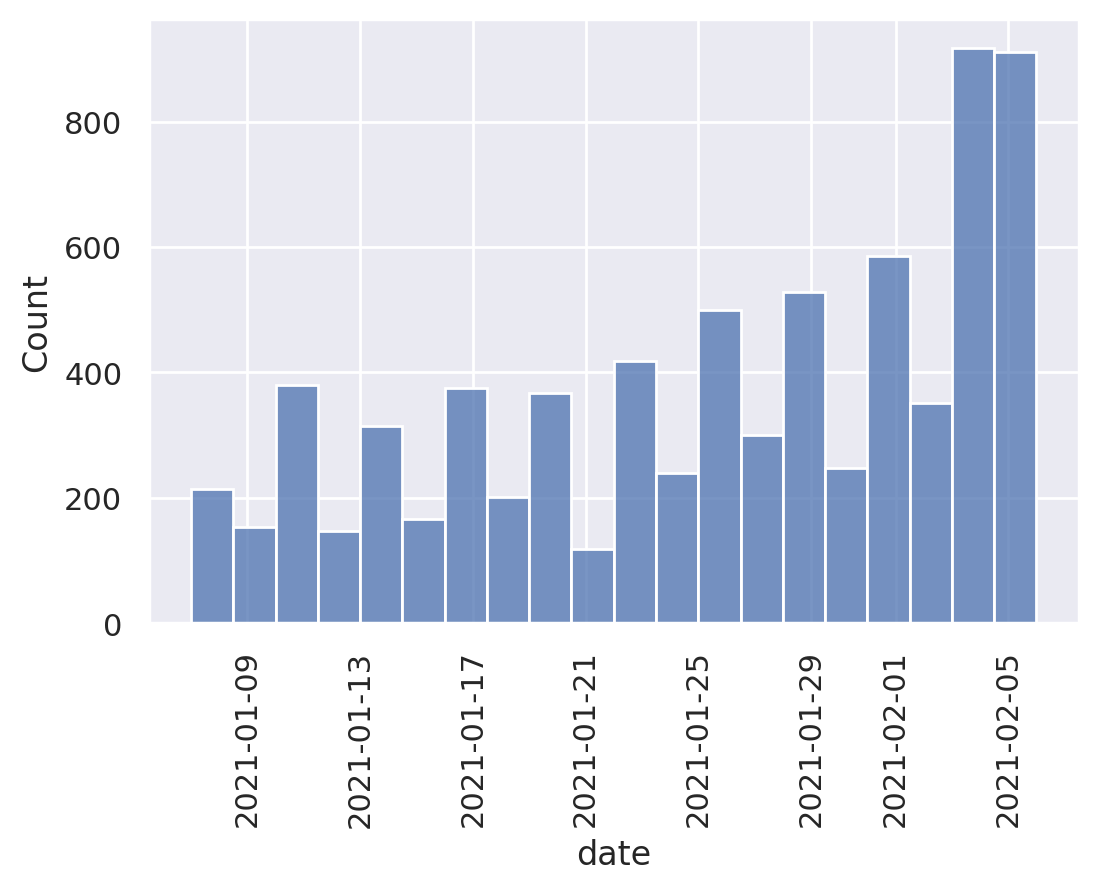

In [ ]:
plt.figure(dpi=200)
plt.xticks(rotation=90)
#sns.countplot(df['date'])
sns.histplot(df['date'])

In [ ]:
df['date'].dt.dayofweek.value_counts()

4    1357
3    1161
5    1111
2    1045
0     977
1     897
6     891
Name: date, dtype: int64

In [ ]:
data.columns

Index(['Şəhər', 'Marka', 'Model', 'Buraxılış ili', 'Ban növü', 'Rəng',
       'Mühərrik', 'Mühərrikin gücü', 'Yanacaq növü', 'Yürüş',
       'Sürətlər qutusu', 'Ötürücü', 'Yeni', 'Qiymət', 'Tarix_Saat',
       'Kateqoriya', 'Baxışların sayı', 'Məhsulun id-si', 'Link',
       'Kredit mümkündür', 'Barter mümkündür', 'Əlaqə nömrəsi',
       'Avtosalon adı', 'Ekstra parametrlər', 'Məhsulun mətni',
       'Yerləşmə məkanı', 'Parsinq olunan tarix', 'Parsinq olunan zaman',
       'existed_in_db'],
      dtype='object')